In [1]:
import pandas as pd
df = pd.read_csv('./sells.txt')
temp_data = df['temparature'].to_numpy()
sells_data = df['sells'].to_numpy()
weather_data = df['weather'].to_numpy()

モデルのパラメタは状態(weather)によって切り替わるが、sells = f(temp)のモデルの式f自体は切り替わらない.

In [2]:
from numpyro import distributions as dist
from numpyro import (
    plate,
    sample,
    infer
)
import jax.numpy as jnp
from jax import random


def model(temp_obs, weather_obs, sells_obs):

    temp_means = sample(
        "temp_means", 
        dist.Normal(loc=jnp.array(30.),
                    scale=jnp.array(2.0)),
    )
    temp_stds = sample(
        "temp_stds", 
        dist.LogNormal(loc=jnp.array(0.),
                       scale=jnp.array(2.)),
    )

    sells_std = sample(
        "sells_std", 
        dist.LogNormal(loc=jnp.array([0., 0.]),
                    scale=jnp.array([5.0, 5.0])),
    )

    with plate("temps_", 2):
        temps = sample(
            "temps",
            dist.Normal(temp_means, temp_stds),
        )

    temp_coeff = sample("temp_coeff",
                        dist.Normal(jnp.array([0., 0.]), jnp.array([1., 1.])),
                        )
    temp_bias = sample("temp_bias",
                       dist.Normal(jnp.array([0., 0.]), jnp.array([100., 100.])),
                       )
    weather_prob = sample("weather_prob",
                         dist.Beta(1.0, 1.0),
                         )

    with plate("days", size=len(temp_data)):
        weather = sample(
            "weather", 
            dist.Bernoulli(probs=weather_prob),
            obs=weather_obs,
        ).astype(jnp.int32)

        temp = sample(
            "temp", 
            dist.Normal(loc=temps[weather], scale=temp_stds),
            obs=temp_obs,
        )

        sells = sample(
            "sells",
            dist.Normal(loc=temp_coeff[weather] * temp + temp_bias[weather], 
                           scale=sells_std[weather]),
            obs=sells_obs,
        )
    return temp, weather, sells


mcmc = infer.MCMC(infer.NUTS(model, max_tree_depth=10), 
                  num_warmup=200, 
                  num_samples=1000, 
                  progress_bar=True,)
mcmc.run(random.PRNGKey(2019), temp_data, weather_data, sells_data)

sample: 100%|██████████| 1200/1200 [00:10<00:00, 109.77it/s, 63 steps of size 7.42e-02. acc. prob=0.93]


In [3]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  sells_std[0]     11.37      1.89     11.13      8.51     14.19    675.73      1.00
  sells_std[1]     10.88      4.43      9.86      5.11     16.83    615.90      1.00
  temp_bias[0]     12.48     13.21     11.13     -9.59     34.24    724.78      1.00
  temp_bias[1]     57.50     26.78     56.32     11.12     97.22   1114.52      1.00
 temp_coeff[0]      3.46      0.42      3.49      2.75      4.14    725.03      1.00
 temp_coeff[1]      0.55      0.87      0.56     -0.80      2.00   1135.34      1.00
    temp_means     30.17      1.74     30.21     27.58     33.27   1175.89      1.00
     temp_stds      5.39      0.71      5.31      4.18      6.44   1368.44      1.00
      temps[0]     30.95      1.11     30.94     29.14     32.71   1114.36      1.00
      temps[1]     30.40      2.05     30.36     27.21     33.73   1208.53      1.00
  weather_prob      0.21      0.07      0.21      0.11      0.33

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('seaborn')

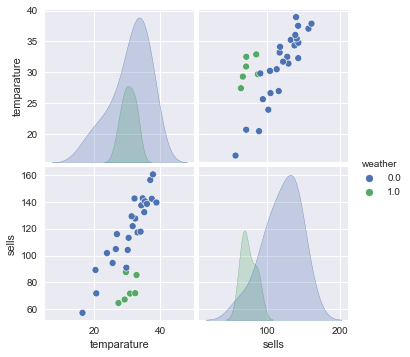

In [5]:
sns.pairplot(df, hue='weather')